# Analyse d'une base de données des clients d'un grossiste 

## Présentation de la base de données

__La base de donnée comprend des grains appartenant à trois variétés différentes de blé : Kama, Rosa et Canadian. La base contient 70 éléments pour chaque variété. Les variables sont quantitatives et sont les suivantes:__

- area (A): Superficie du grain
- perimeter (P): Périmètre
- compactness: Compacité
- length of kernel: longueur du noyau
- width of kernel: largeur du noyau 
- asymmetry coefficient: coefficient d'asymétrie 
- length of kernel groove: longueur de la rainure du noyau

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections

"""
 For CPA
"""
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

"""
 For ACM
"""
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import cluster
from sklearn import metrics

In [19]:
# Import des données
data = pd.read_csv('Acp_classification_Data.csv')
data.head()
data.shape

(210, 8)

## Enoncé

__1. Extraire les données quantitatives et présenter une synthèse des données.__

__2. Analyse ACP:__
   - Effectuer une analyse ACP avec deux dimensions, afficher les valeurs propres et les ratios de variance expliquée par chaque composante. 
   - Quelle quantité d'information est préservée dans ce cas ?
   - Utiliser les métriques, que suggèrent chacune par rapport au nombre de dimensions à garder ? (justifier le raisonnement)
   - Calculer les contributions et les qualités de représentation des individus et des variables par rapport à chacun des            facteurs que vous avez gardés, et analyser.
   - 5.	Afficher le graphique des individus. Utiliser une couleur différente pour chaque classe de grains et analyser ?
   - Calculer les corrélations des variables avec chacun des axes, tracer le cercle des corrélations en prenant deux à deux les      facteurs que avez gardés et analyser.
   
__3. Classification__
   - Effectuer une classification Ascendente Hierarchique : tracer le dendrogramme, utiliser le tracé pour determiner le nombre      de classe à retenir (justifier le raisonnement).
   - Effectuer une classification K-means en utilisant le nombre de classe retenue avec la CAH. 
   - Que suggère la métrique silhouette concernant le nombre de classes K-means ? (justifier le raisonnement)
   - Comparer les classes obtenues avec la CAH et les classes obtenues par K-means, analyser.
   - Etudier les classes obtenues par K-means, analyser les propriétés des grains qui composent chacune des classes.   

In [6]:
mat = data.values
mat

array([[15.26  , 14.84  ,  0.871 , ...,  2.221 ,  5.22  ,  0.    ],
       [14.88  , 14.57  ,  0.8811, ...,  1.018 ,  4.956 ,  0.    ],
       [14.29  , 14.09  ,  0.905 , ...,  2.699 ,  4.825 ,  0.    ],
       ...,
       [13.2   , 13.66  ,  0.8883, ...,  8.315 ,  5.056 ,  2.    ],
       [11.84  , 13.21  ,  0.8521, ...,  3.598 ,  5.044 ,  2.    ],
       [12.3   , 13.34  ,  0.8684, ...,  5.637 ,  5.063 ,  2.    ]])

In [7]:
sc = StandardScaler() 
Z = sc.fit_transform(mat) 
print(Z) 

In [8]:
print(np.mean(Z,axis=0))
# moyenne tres proche de 0 

[-3.38353684e-16  1.18423789e-16  1.28574400e-15 -2.09779284e-15
 -3.38353684e-16 -3.38353684e-16 -8.98751972e-17  0.00000000e+00]


In [9]:
print(np.std(Z,axis=0,ddof=0)) 
# les ecart type sont bien a 1

[1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
#instanciation pour l'ACP
# full : nbre de composantes principales = nbre de variables
acp = PCA(svd_solver='full')
coord = acp.fit_transform(Z)

#nombre de composantes calculées
print(acp.n_components_)
n = (acp.n_components_)

8


In [14]:
# Calcul des valeurs propres
variance = acp.explained_variance_
eigval = variance*(len(Z)-1)/len(Z) #ajustement suite à la version 0.2
print(eigval)

[5.18713606e+00 1.69788054e+00 6.79051624e-01 3.69440974e-01
 4.51347860e-02 1.53349541e-02 5.33084981e-03 6.90210517e-04]


In [15]:
#ratio de réprésentation des valeurs prores
print([ratio for ratio in acp.explained_variance_ratio_])

# D'apres le ratio, il suffit juste de prendre 2 composantes pour avoir environ 85% des informations

[0.6483920080248546, 0.21223506712599635, 0.0848814530612325, 0.04618012173968063, 0.005641848246017328, 0.0019168692617957104, 0.0006663562257517448, 8.627631467115576e-05]


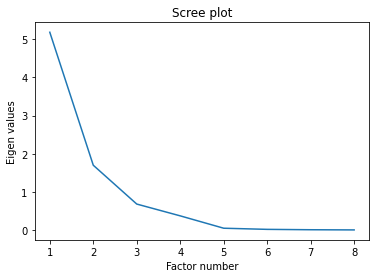

In [16]:
#scree plot
plt.plot(np.arange(1,n+1),eigval)
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.show()

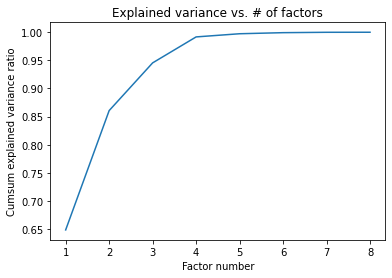

In [17]:
#cumul de variance expliquée
plt.plot(np.arange(1,n+1),np.cumsum(acp.explained_variance_ratio_))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
plt.show()

In [18]:
# methode de baton brisee pour deteminer nbre de cp
bs = 1/np.arange(n,0,-1)
# 1/5,1/4,1/3,1/2,1
bs = np.cumsum(bs)
bs = bs[::-1]
#test des bâtons brisés
print(pd.DataFrame({'Val.Propre':eigval,'Seuils':bs}))
# On s'arrete lorsque cum seuilles > valeur propre 
# La somme des 3 premiers composantes depasse 5.19, qui est vp la plus grande)
# On garde 3 composantes

   Val.Propre    Seuils
0    5.187136  2.717857
1    1.697881  1.717857
2    0.679052  1.217857
3    0.369441  0.884524
4    0.045135  0.634524
5    0.015335  0.434524
6    0.005331  0.267857
7    0.000690  0.125000


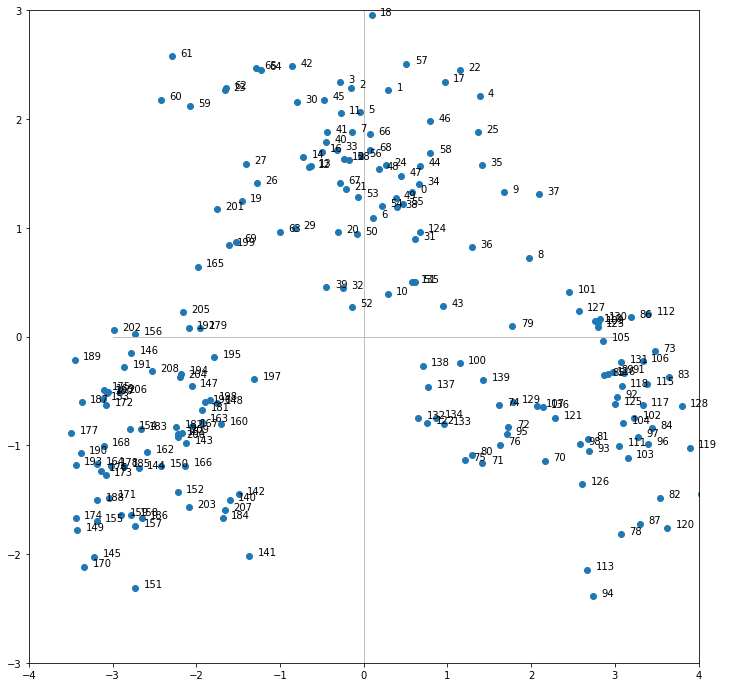

In [66]:
#positionnement des individus dans le premier plan
fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-4,4) #même limites en abscisse
axes.set_ylim(-3,3) #et en ordonnée

# placement des points
plt.scatter(coord[:,0],coord[:,1])

#placement des étiquettes des observations
for i in range(210):
     plt.annotate(data.index[i],(coord[i,0]+0.1,coord[i,1]))
#ajouter les axes
plt.plot([-3,3],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)
#affichage
plt.show()

In [23]:
#Executer la cellule de qualite d'abord
#contribution des individus dans l'inertie totale
di = np.sum(Z**2,axis=1)
print(pd.DataFrame({'ID':data.index,'d_i':di}))

      ID        d_i
0      0   2.798871
1      1   5.798879
2      2   6.233236
3      3   5.939532
4      4   7.020030
..   ...        ...
205  205   6.508467
206  206   9.018348
207  207  13.611917
208  208   7.155410
209  209   6.652034

[210 rows x 2 columns]


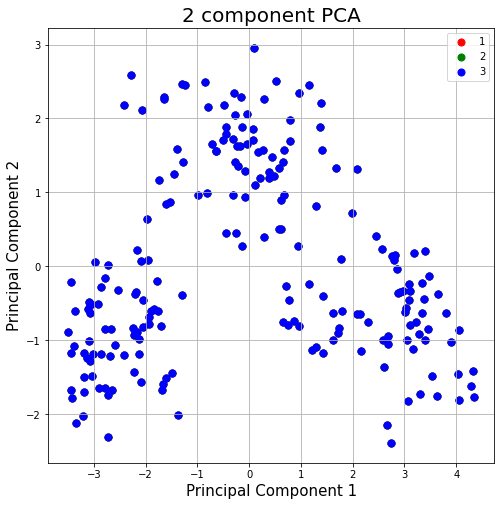

In [65]:
# Creer une figure
fig = plt.figure(figsize = (8,8))

# Creer un graphe pour la figure
ax = fig.add_subplot(1,1,1)

# Nommer les axes et le graphe
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['1', '2','3']
colors = ['r','g','b']

for target, color in zip(targets,colors):
    # Selectionner species_name = target puis donner c=color
    ax.scatter(coord[:,0],coord[:,1], c = color, s = 50)
    
ax.legend(targets)
ax.grid()

In [24]:
#contributions aux axes
ctr = coord**2
for j in range(8):
     ctr[:,j] = ctr[:,j]/(210*eigval[j])

print(pd.DataFrame({'id':data.index,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1]}))

      id     CTR_1     CTR_2
0      0  0.000302  0.004959
1      1  0.000080  0.014411
2      2  0.000022  0.014716
3      3  0.000074  0.015338
4      4  0.001757  0.013692
..   ...       ...       ...
205  205  0.004289  0.000142
206  206  0.007811  0.000732
207  207  0.002518  0.007150
208  208  0.005861  0.000283
209  209  0.004330  0.002190

[210 rows x 3 columns]


In [70]:
# On affiche les 5 individus qui contribuent le plus a l'axe 1
tab=pd.DataFrame({'id':data.index,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1]})
tab.nlargest(10, columns=['CTR_1'])

id     CTR_1     CTR_2
88    88  0.017329  0.008781
89    89  0.017136  0.005605
114  114  0.016794  0.007378
90    90  0.015116  0.002106
77    77  0.015056  0.009109
108  108  0.014944  0.005900
119  119  0.013945  0.002927
128  128  0.013240  0.001136
83    83  0.012242  0.000393
120  120  0.012086  0.008649

In [71]:
# On affiche les 5 individus qui contribuent le plus a l'axe 2
tab.nlargest(10, columns=['CTR_2'])
# On observe qu'il n'existe pas un individu qui apparait deux fois

id     CTR_1     CTR_2
18  18  0.000008  0.024528
61  61  0.004801  0.018699
57  57  0.000239  0.017681
42  42  0.000678  0.017360
65  65  0.001526  0.017144
64  64  0.001392  0.016918
22  22  0.001217  0.016869
94  94  0.006908  0.016011
17  17  0.000865  0.015439
3    3  0.000074  0.015338

In [25]:
#le champ components_ de l'objet ACP
print(acp.components_)

[[ 0.43548379  0.43164567  0.28699071  0.41102512  0.42828621 -0.13965753
   0.36465431 -0.19189712]
 [-0.08082488 -0.11727215  0.35972327 -0.20138426  0.02983049 -0.55560659
  -0.38186129 -0.59527434]
 [ 0.02699035 -0.06274185  0.65905286 -0.22206055  0.22463489  0.63983095
  -0.2241315   0.03992503]
 [ 0.01006832 -0.06446452  0.37492868 -0.17295887  0.08927485 -0.511578
   0.05457218  0.74336835]
 [ 0.26132543  0.3046541  -0.32810705  0.05778331  0.32627958 -0.01699613
  -0.76052907  0.20676085]
 [ 0.12121499  0.13513444 -0.28092369 -0.79719638  0.39204228 -0.0065699
   0.29565268 -0.10702612]
 [-0.42830865 -0.47459965 -0.14252979  0.26881355  0.70440081 -0.01918675
   0.04667083 -0.0021497 ]
 [ 0.73250188 -0.67491983 -0.08016368  0.01246459 -0.0302362   0.00111025
  -0.00173028 -0.02059569]]


In [26]:
#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

In [27]:
#corrélation des variables avec les axes
corvar = np.zeros((8,8))
for k in range(8):
     corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

#afficher la matrice des corrélations variables x facteurs
print(corvar)

[[ 9.91826751e-01 -1.05317044e-01  2.22412874e-02  6.11969034e-03
   5.55184537e-02  1.50105838e-02 -3.12719573e-02  1.92441853e-02]
 [ 9.83085316e-01 -1.52808836e-01 -5.17021636e-02 -3.91826051e-02
   6.47236091e-02  1.67342899e-02 -3.46517868e-02 -1.77313979e-02]
 [ 6.53629521e-01  4.68729295e-01  5.43089801e-01  2.27887861e-01
  -6.97061745e-02 -3.47880118e-02 -1.04064803e-02 -2.10604874e-03]
 [ 9.36121414e-01 -2.62409217e-01 -1.82988082e-01 -1.05127267e-01
   1.22760345e-02 -9.87203214e-02  1.96267946e-02  3.27467899e-04]
 [ 9.75434039e-01  3.88699419e-02  1.85109455e-01  5.42627304e-02
   6.93179314e-02  4.85483129e-02  5.14301828e-02 -7.94361247e-04]
 [-3.18073998e-01 -7.23970636e-01  5.27250066e-01 -3.10945580e-01
  -3.61081967e-03 -8.13579619e-04 -1.40087564e-03  2.91683717e-05]
 [ 8.30510574e-01 -4.97575748e-01 -1.84694637e-01  3.31698727e-02
  -1.61574014e-01  3.66119673e-02  3.40756191e-03 -4.54576008e-05]
 [-4.37051166e-01 -7.75658809e-01  3.29000580e-02  4.51831593e-01
   

In [28]:
#on affiche pour les deux premiers axes les correlations
print(pd.DataFrame({'id':data.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]}))

       id     COR_1     COR_2
0       A  0.991827 -0.105317
1       P  0.983085 -0.152809
2       C  0.653630  0.468729
3      LK  0.936121 -0.262409
4      WK  0.975434  0.038870
5  A_Coef -0.318074 -0.723971
6     LKG  0.830511 -0.497576
7  target -0.437051 -0.775659


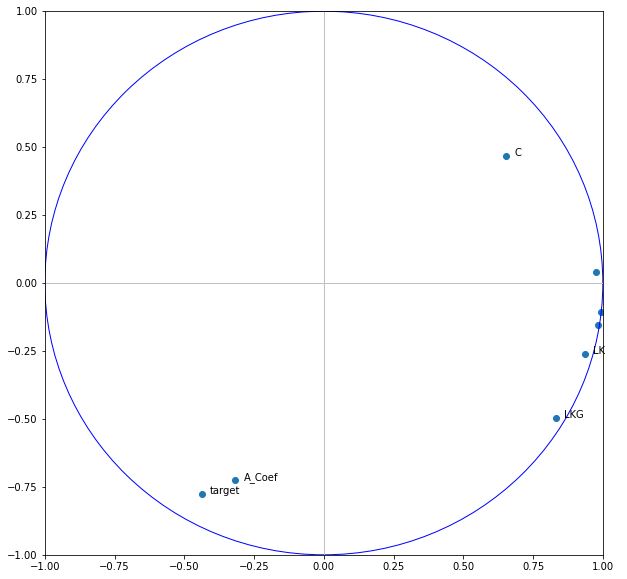

In [74]:
#cercle des corrélations pour les deux premiers axes
fig, axes = plt.subplots(figsize=(10,10))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)

# les points
plt.scatter(corvar[:,0],corvar[:,1])

#affichage des étiquettes (noms des variables)
for j in range(8):
     plt.annotate(data.columns[j],(corvar[j,0]+0.03,corvar[j,1]))

#ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

#ajouter un cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)

#affichage
plt.show()

In [ ]:
# Cercle de correlation
# sur axe 1, la plupart des variables sont correlees positivement avec axe 1 sauf a_coef et target
# sur axe 2, la plupart des variables sont correlees negativement avec axe 2 sauf C et WK

In [31]:
#cosinus carré des variables
cos2var = corvar**2
print(pd.DataFrame({'id':data.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1]}))
tab.nlargest(10, columns=['CTR_1'])

       id    COS2_1    COS2_2
0       A  0.983720  0.011092
1       P  0.966457  0.023351
2       C  0.427232  0.219707
3      LK  0.876323  0.068859
4      WK  0.951472  0.001511
5  A_Coef  0.101171  0.524133
6     LKG  0.689748  0.247582
7  target  0.191014  0.601647


In [ ]:
# Qualite de representation des variables
# sur axe 1, les variables qui sont mieux representees sont A, P et WK
# sur axe 2, la variable qui est bien representee est A_Coef et target
# En generale, les variables sont mieux represntees en axe 1 que en axe 2 sauf pour A_Coef et target.

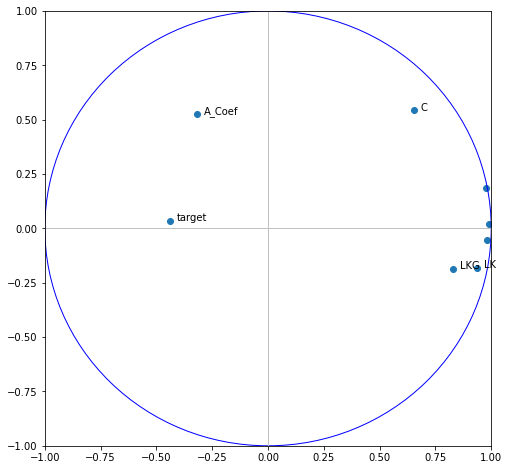

In [33]:
#cercle des corrélations pour l'axe 1 et 3
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)

# les points
plt.scatter(corvar[:,0],corvar[:,2])

#affichage des étiquettes (noms des variables)
for j in range(8):
     plt.annotate(data.columns[j],(corvar[j,0]+0.03,corvar[j,2]))

#ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

#ajouter un cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)
#affichage
plt.show()

In [35]:
#cosinus carré des variables
cos2var = corvar**2
print(pd.DataFrame({'id':data.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,2]}))  

       id    COS2_1    COS2_2
0       A  0.983720  0.000495
1       P  0.966457  0.002673
2       C  0.427232  0.294947
3      LK  0.876323  0.033485
4      WK  0.951472  0.034266
5  A_Coef  0.101171  0.277993
6     LKG  0.689748  0.034112
7  target  0.191014  0.001082


In [ ]:
# Qualite de representation des variables
# sur axe 3, la variable qui est bien representee est A_Coef et C, mais elles sont pas assez bien representees
# En generale, les variables sont mieux represntees en axe 1 que en axe 3

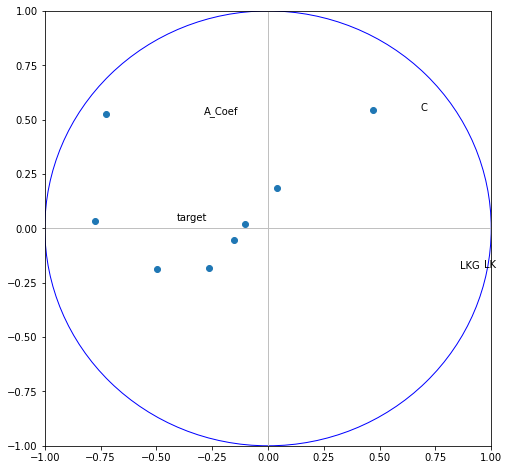

In [72]:
#cercle des corrélations pour l'axe 2 et 3
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)

# les points
plt.scatter(corvar[:,1],corvar[:,2])

#affichage des étiquettes (noms des variables)
for j in range(8):
     plt.annotate(data.columns[j],(corvar[j,0]+0.03,corvar[j,2]))

#ajouter les axes
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

#ajouter un cercle
cercle = plt.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)
#affichage
plt.show()

In [73]:
#cosinus carré des variables
cos2var = corvar**2
print(pd.DataFrame({'id':data.columns,'COS2_1':cos2var[:,1],'COS2_2':cos2var[:,2]}))  

       id    COS2_1    COS2_2
0       A  0.011092  0.000495
1       P  0.023351  0.002673
2       C  0.219707  0.294947
3      LK  0.068859  0.033485
4      WK  0.001511  0.034266
5  A_Coef  0.524133  0.277993
6     LKG  0.247582  0.034112
7  target  0.601647  0.001082


In [ ]:
# Classification

In [36]:
# Donnees centrees reduites
data_cr = sc.fit_transform(data.values) 

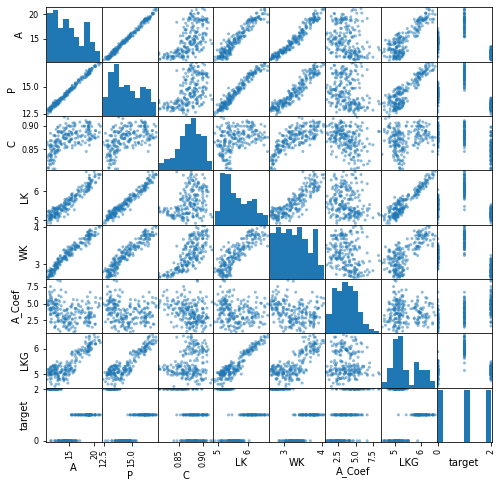

In [39]:
#graphique - croisement deux à deux des variables
from pandas.plotting import scatter_matrix
scatt_mat = scatter_matrix(data,figsize=(8,8))[-1]

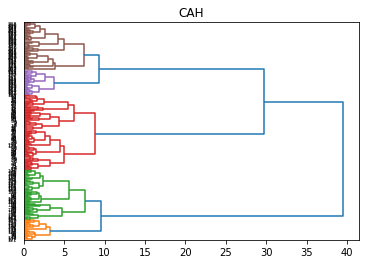

In [44]:
#librairies pour la CAH

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

#générer la matrice des liens

Z = linkage(data_cr,method='ward',metric='euclidean')

#affichage du dendrogramme

plt.title("CAH")
dendrogram(Z,labels=data.index,orientation='right',color_threshold=9)
plt.show()

In [ ]:
# hauteur t =9
# identifiants de 5 groupes obtenus

In [48]:
groupes_cah = fcluster(Z,t=9,criterion='distance')
print(groupes_cah)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 2
 1 1 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 1 2 3 2 1 2 2 2 2 2 1 1 1 3 1 1 1 1 5 5 5 5 4 4 5 5
 5 4 5 4 4 4 4 4 5 4 4 4 5 5 5 5 5 5 5 5 4 4 4 5 4 4 4 5 4 4 5 5 5 5 5 5 5
 4 4 4 5 5 4 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


In [49]:
#index triés des groupes

idg = np.argsort(groupes_cah)

#affichage des observations et leurs groupes

print(pd.DataFrame(data.index[idg],groupes_cah[idg]))

      0
1    70
1   100
1   121
1   122
1    80
..  ...
5   179
5   180
5   181
5   183
5   209

[210 rows x 1 columns]


In [50]:
#k-means sur les données centrées et réduites

from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=5)  # on choisit 5 avec l'étude du dessus
kmeans.fit(data_cr)

#index triés des groupes

print(kmeans.labels_)
idk = np.argsort(kmeans.labels_)

#affichage des observations et leurs groupes

print(pd.DataFrame(data.index[idk],kmeans.labels_[idk]))

[2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 0 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 3
 0 0 0 3 3 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 0 3 3 3 3 3 3 0 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 0 3 2 3 3 3 3 0 3 3 0 0 0 0 0 0 0 0 1 4 4 4 1 1 1 4
 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 4 4 4 1 1 1 1 1 4 1 1 1 4 1 1 1 1 4 4 4 4 4
 1 1 1 4 4 1 4 4 1 4 4 4 4 1 4 4 4 4 4 4 4 1 4 1 4]
      0
0    71
0    95
0    37
0    36
0    70
..  ...
4   182
4   184
4   188
4   142
4   209

[210 rows x 1 columns]


In [51]:
#distances aux centres de classes des observations

dist_data = pd.DataFrame(kmeans.transform(data_cr),index = data.index)
print(dist_data)

            0         1         2         3         4
0    2.012163  4.178220  1.085010  3.498439  3.855254
1    2.956800  4.577213  1.189081  4.265077  4.127140
2    3.181467  4.571740  1.270144  4.664869  3.608254
3    3.206339  4.413216  1.038921  4.724403  3.591022
4    2.631578  5.377199  1.880079  3.508436  4.651755
..        ...       ...       ...       ...       ...
205  3.894239  2.210130  2.931740  5.590030  1.084676
206  4.356266  0.953920  3.561682  6.141199  1.069407
207  4.330559  3.686106  4.589729  5.755352  2.507262
208  4.042136  1.107878  3.242467  5.788007  1.224303
209  3.759220  1.763473  3.436037  5.492419  0.444970

[210 rows x 5 columns]


In [52]:
#correspondance avec les groupes de la CAH

pd.crosstab(groupes_cah,kmeans.labels_)

col_0   0   1   2   3   4
row_0                    
1      18   0   0   2   0
2       2   0   0  46   0
3       7   0  65   0   0
4       0  24   0   0   0
5       0  14   0   0  32

[0.40894672 0.4850202  0.38954713 0.30502083 0.26161726 0.25877873
 0.26441364 0.25756311 0.2548676  0.25890665 0.25581253 0.24996936
 0.25075564 0.24219816 0.2498287 ]


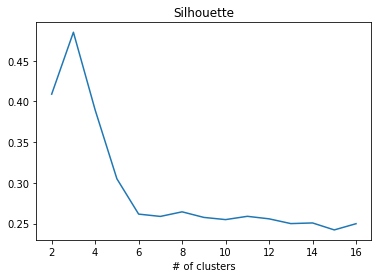

In [77]:
#librairie pour évaluation des partitions
from sklearn import metrics

#utilisation de la métrique "silhouette"
res = np.arange(15,dtype="double")
for k in np.arange(15):
    km = cluster.KMeans(n_clusters=k+2)
    km.fit(data_cr)
    res[k] = metrics.silhouette_score(data_cr,km.labels_)
print(res)

#graphique
import matplotlib.pyplot as plt
plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,17,1),res)
plt.show()

In [ ]:
# Nbre de cluster d'apres silhouette = 3 
# Nbre de cluster k-means = 5 